In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from io import StringIO
import missingno as msno
from sklearn.impute import SimpleImputer

from patsy import demo_data
from patsy import dmatrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer

import scipy as sp
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

import warnings

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family='NanumGothic') # 폰트 설정
mpl.rc('axes', unicode_minus=False) # 유니코드에서 음수 부호 설정

# 차트 스타일 설정
sns.set(font="NanumGothic", rc={"axes.unicode_minus":False}, style='darkgrid')

warnings.filterwarnings("ignore")

# 4.1 회귀분석 예제

## 4.1.1 보스턴 집값 예측

sklearn 패키지의 datasets 서브패키지는 회귀분석을 공부하기 위한 예제를 제공한다. 그 중 `load_boston()` 명령으로 받을 수 있는 보스턴 주택 가격 데이터는 다음과 같은 데이터이다. 보스턴의 506개 타운(town)의 13개 독립변수값로부터 해당 타운의 주택가격 중앙값을 예측하는 문제다. 사용할 수 있는 특징 데이터는 다음과 같다.

* 독립변수
 * CRIM: 범죄율
 * INDUS: 비소매상업지역 면적 비율
 * NOX: 일산화질소 농도 
 * RM: 주택당 방 수
 * LSTAT: 인구 중 하위 계층 비율
 * B: 인구 중 흑인 비율
 * PTRATIO: 학생/교사 비율
 * ZN: 25,000 평방피트를 초과 거주지역 비율
 * CHAS: 찰스강의 경계에 위치한 경우는 1, 아니면 0
 * AGE: 1940년 이전에 건축된 주택의 비율
 * RAD: 방사형 고속도로까지의 거리
 * DIS: 직업센터의 거리
 * TAX:	재산세율


* 종속변수
 * 보스턴 506개 타운의 1978년 주택 가격 중앙값 (단위 1,000 달러)

`load_boston` 명령으로 받는 데이터 집합은 `Bunch` 라는 클래스 객체로 생성된다. 이 클래스 객체는 다음과 같은 속성을 가진다.


 * `data`: 독립변수 `ndarray` 배열
 * `target`: 종속변수 `ndarray` 배열
 * `feature_names`: 독립변수 이름 리스트
 * `target_names`: (옵션) 종속변수 이름 리스트
 * `DESCR`: (옵션) 자료에 대한 설명 문자열

**Boston 데이터 불러오기**

In [3]:
from sklearn.datasets import load_boston

temp = load_boston()
dir(temp)

['DESCR', 'data', 'feature_names', 'filename', 'target']

In [4]:
x_data = pd.DataFrame(temp.data, columns = temp.feature_names)
y_data = pd.DataFrame(temp.target, columns = ["MEDV"])

boston = pd.concat([x_data, y_data], axis = 1)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


**일부 변수 시각화**

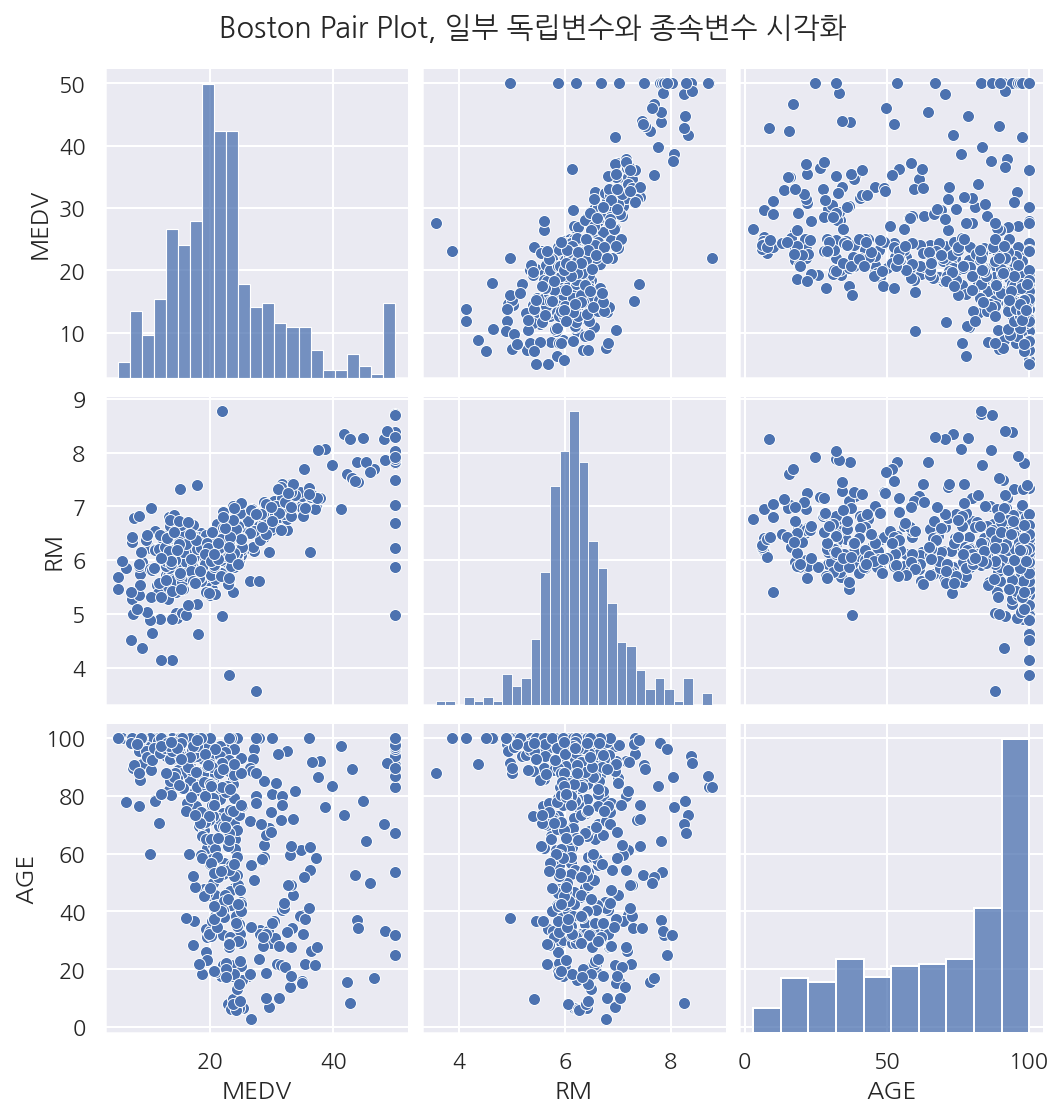

In [5]:
sns.pairplot(boston[["MEDV", "RM", "AGE"]])
plt.suptitle("Boston Pair Plot, 일부 독립변수와 종속변수 시각화", y=1.03)
plt.show()

- 방 개수(RM)가 증가할 수록 집값(MEDV)은 증가하는 경향이 보인다.


- 노후화 정도(AGE)와 집값은 관계(MEDV)가 없어 보인다.

## 4.1.2 당뇨병 진행도 예측

scikit-learn 패키지가 제공하는 당뇨병 진행도 예측용 데이터는 442명의 당뇨병 환자를 대상으로한 검사 결과를 나타내는 데이터이다.

* 독립변수 [모두 스케일링(scaling)되어있음.]

 * age: 나이

 * sex: 성별

 * bmi: BMI(Body mass index)지수

 * bp: 평균혈압

 * s1~s6: 6종류의 혈액검사수치
 

* 종속변수
 * 1년 뒤 측정한 당뇨병의 진행률

**Diabetes 데이터 불러오기**

In [6]:
from sklearn.datasets import load_diabetes

temp = load_diabetes()
diabetes = pd.DataFrame(temp.data, columns=temp.feature_names)
diabetes["target"] = temp.target
diabetes.tail()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485,104.0
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491,132.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930,220.0
441,-0.045472,-0.044642,-0.073030,-0.081414,0.083740,0.027809,0.173816,-0.039493,-0.004220,0.003064,57.0


**일부 변수 시각화**

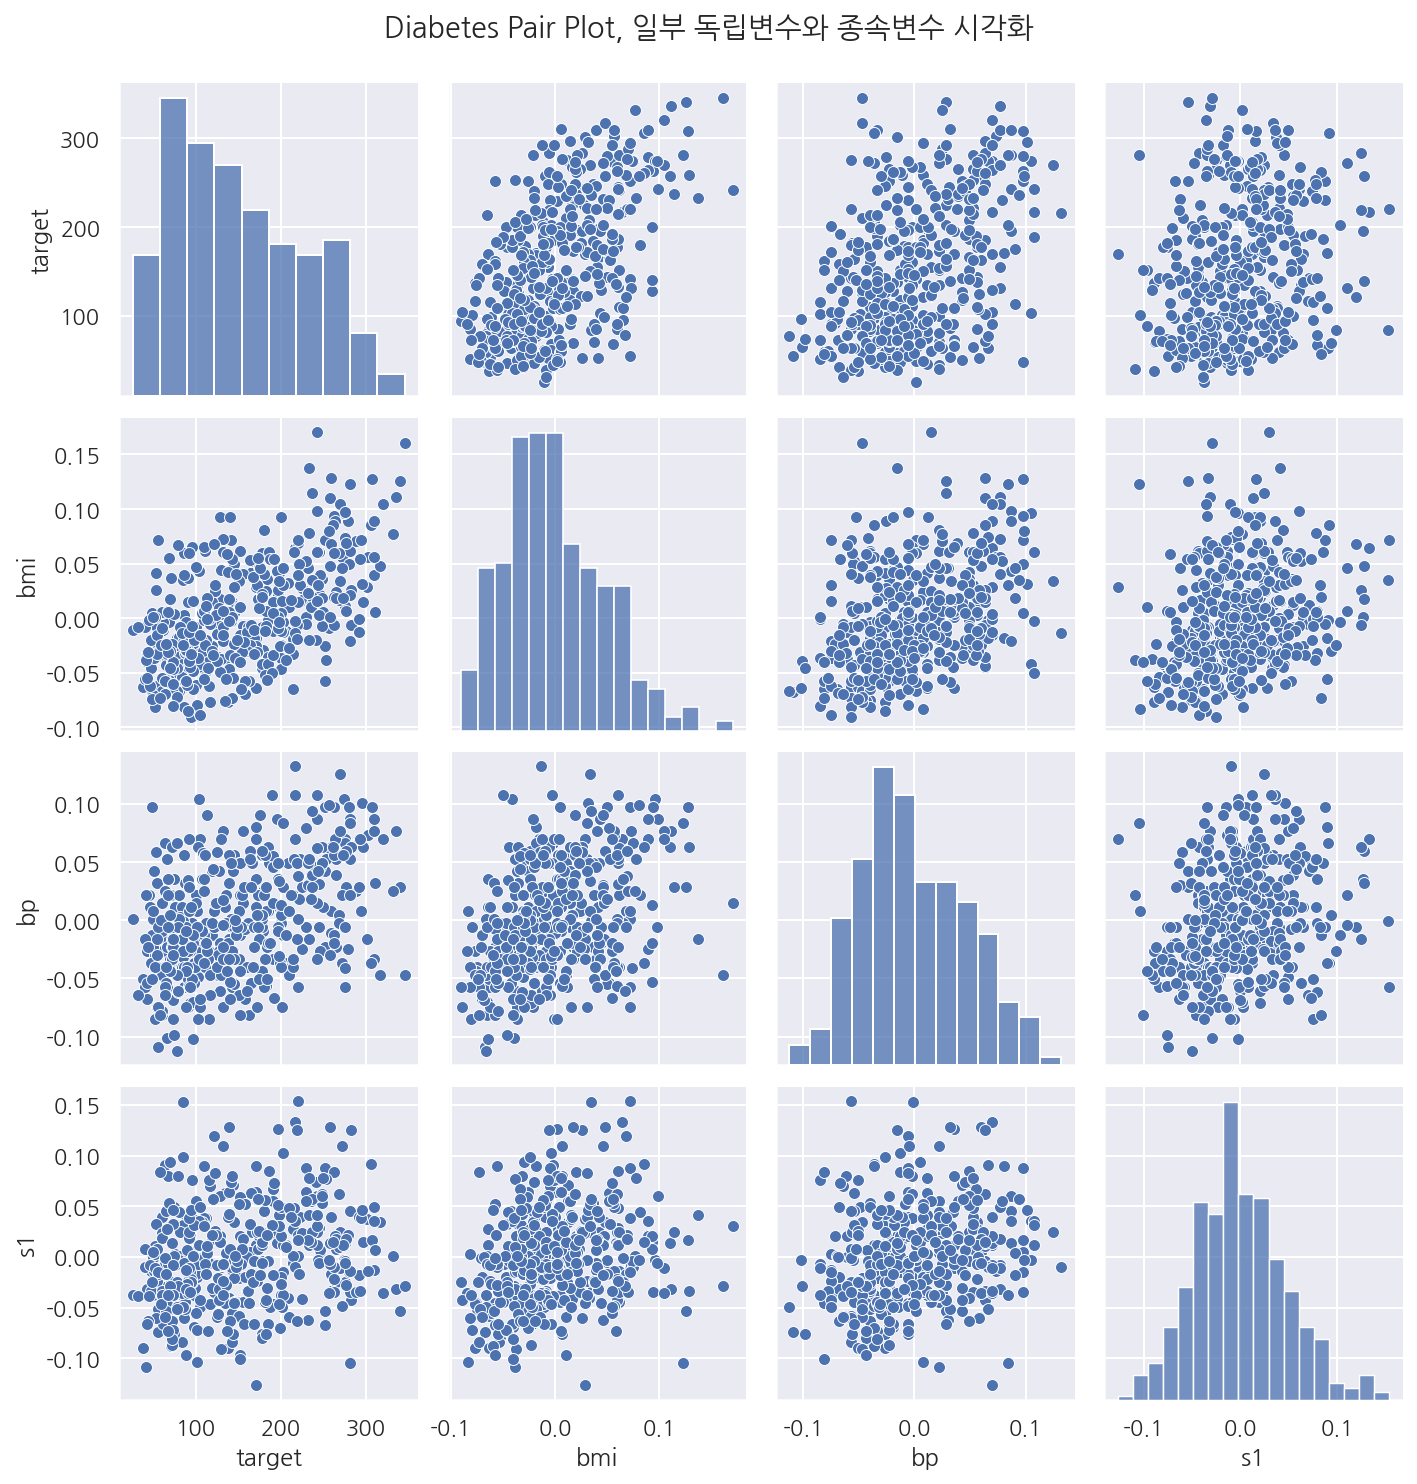

In [7]:
sns.pairplot(diabetes[["target", "bmi", "bp", "s1"]])
plt.suptitle("Diabetes Pair Plot, 일부 독립변수와 종속변수 시각화", y=1.03)
plt.show()

- 독립변수 BMI지수와 평균혈압은 종속변수인 당뇨병 진행도와 양의 상관관계를 가지는 것을 볼 수 있다. 


- 독립변수 BMI지수와 평균혈압도 서로 양의 상관관계를 가져 다중공선성이 보인다.

## 4.1.3 연습문제

sklearn.datasets 패키지의 fetch_california_housing 명령은 캘리포니아 주택가격을 예측하기위한 데이터다. 이 데이터의 독립변수를 조사하고 어떤 데이터들이 주택가격과 상관관계가 있는지를 조사한다. 또한 서로 강한 상관관계를 가지는 독립변수도 알아보자.

**California 데이터 불러오기**

In [8]:
from sklearn.datasets import fetch_california_housing

temp = fetch_california_housing()

california = pd.DataFrame(temp.data, columns=temp.feature_names)
california["MedHouseVal"] = temp.target
california.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


**상관관계 확인**

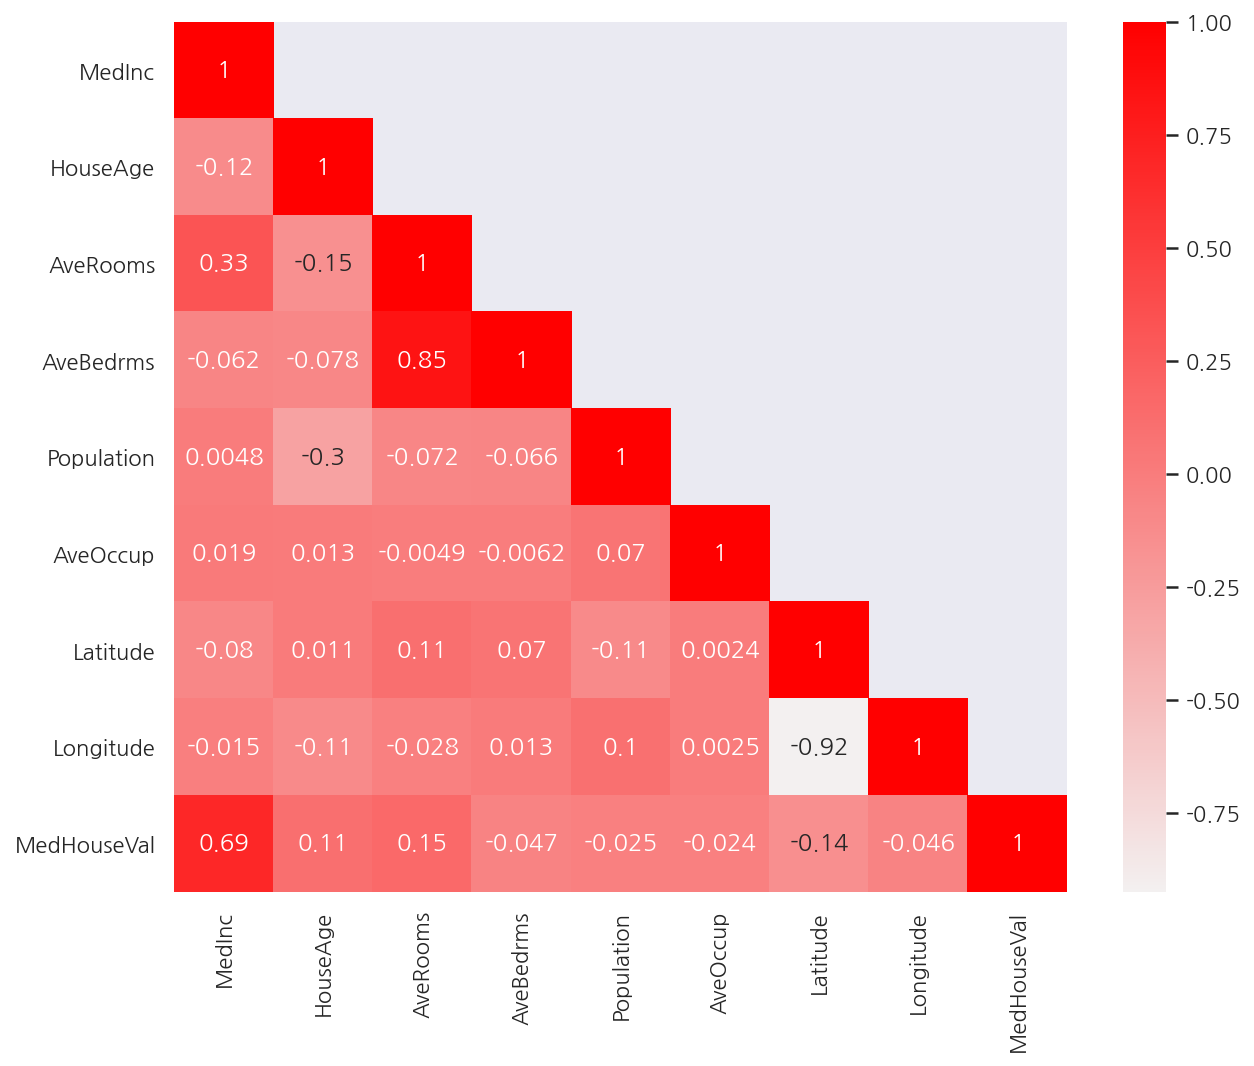

In [9]:
corr_M = california.corr()
mask = np.array(corr_M)
mask[np.tril_indices_from(mask)] = False

plt.figure(figsize= (10,8))

sns.heatmap(corr_M, 
            cmap = sns.light_palette("red", as_cmap=True),
            annot = True, 
            mask = mask)

plt.show()

- 종속변수 MedHouseVal와 상관관계가 높은 독립변수는 MedInc이다.


- 독립변수간에는 AveRooms와 AveBedrms, Latitude와 Longitude가 서로 강한 상관관계를 가지고 있다. 

**일부 변수 시각화**

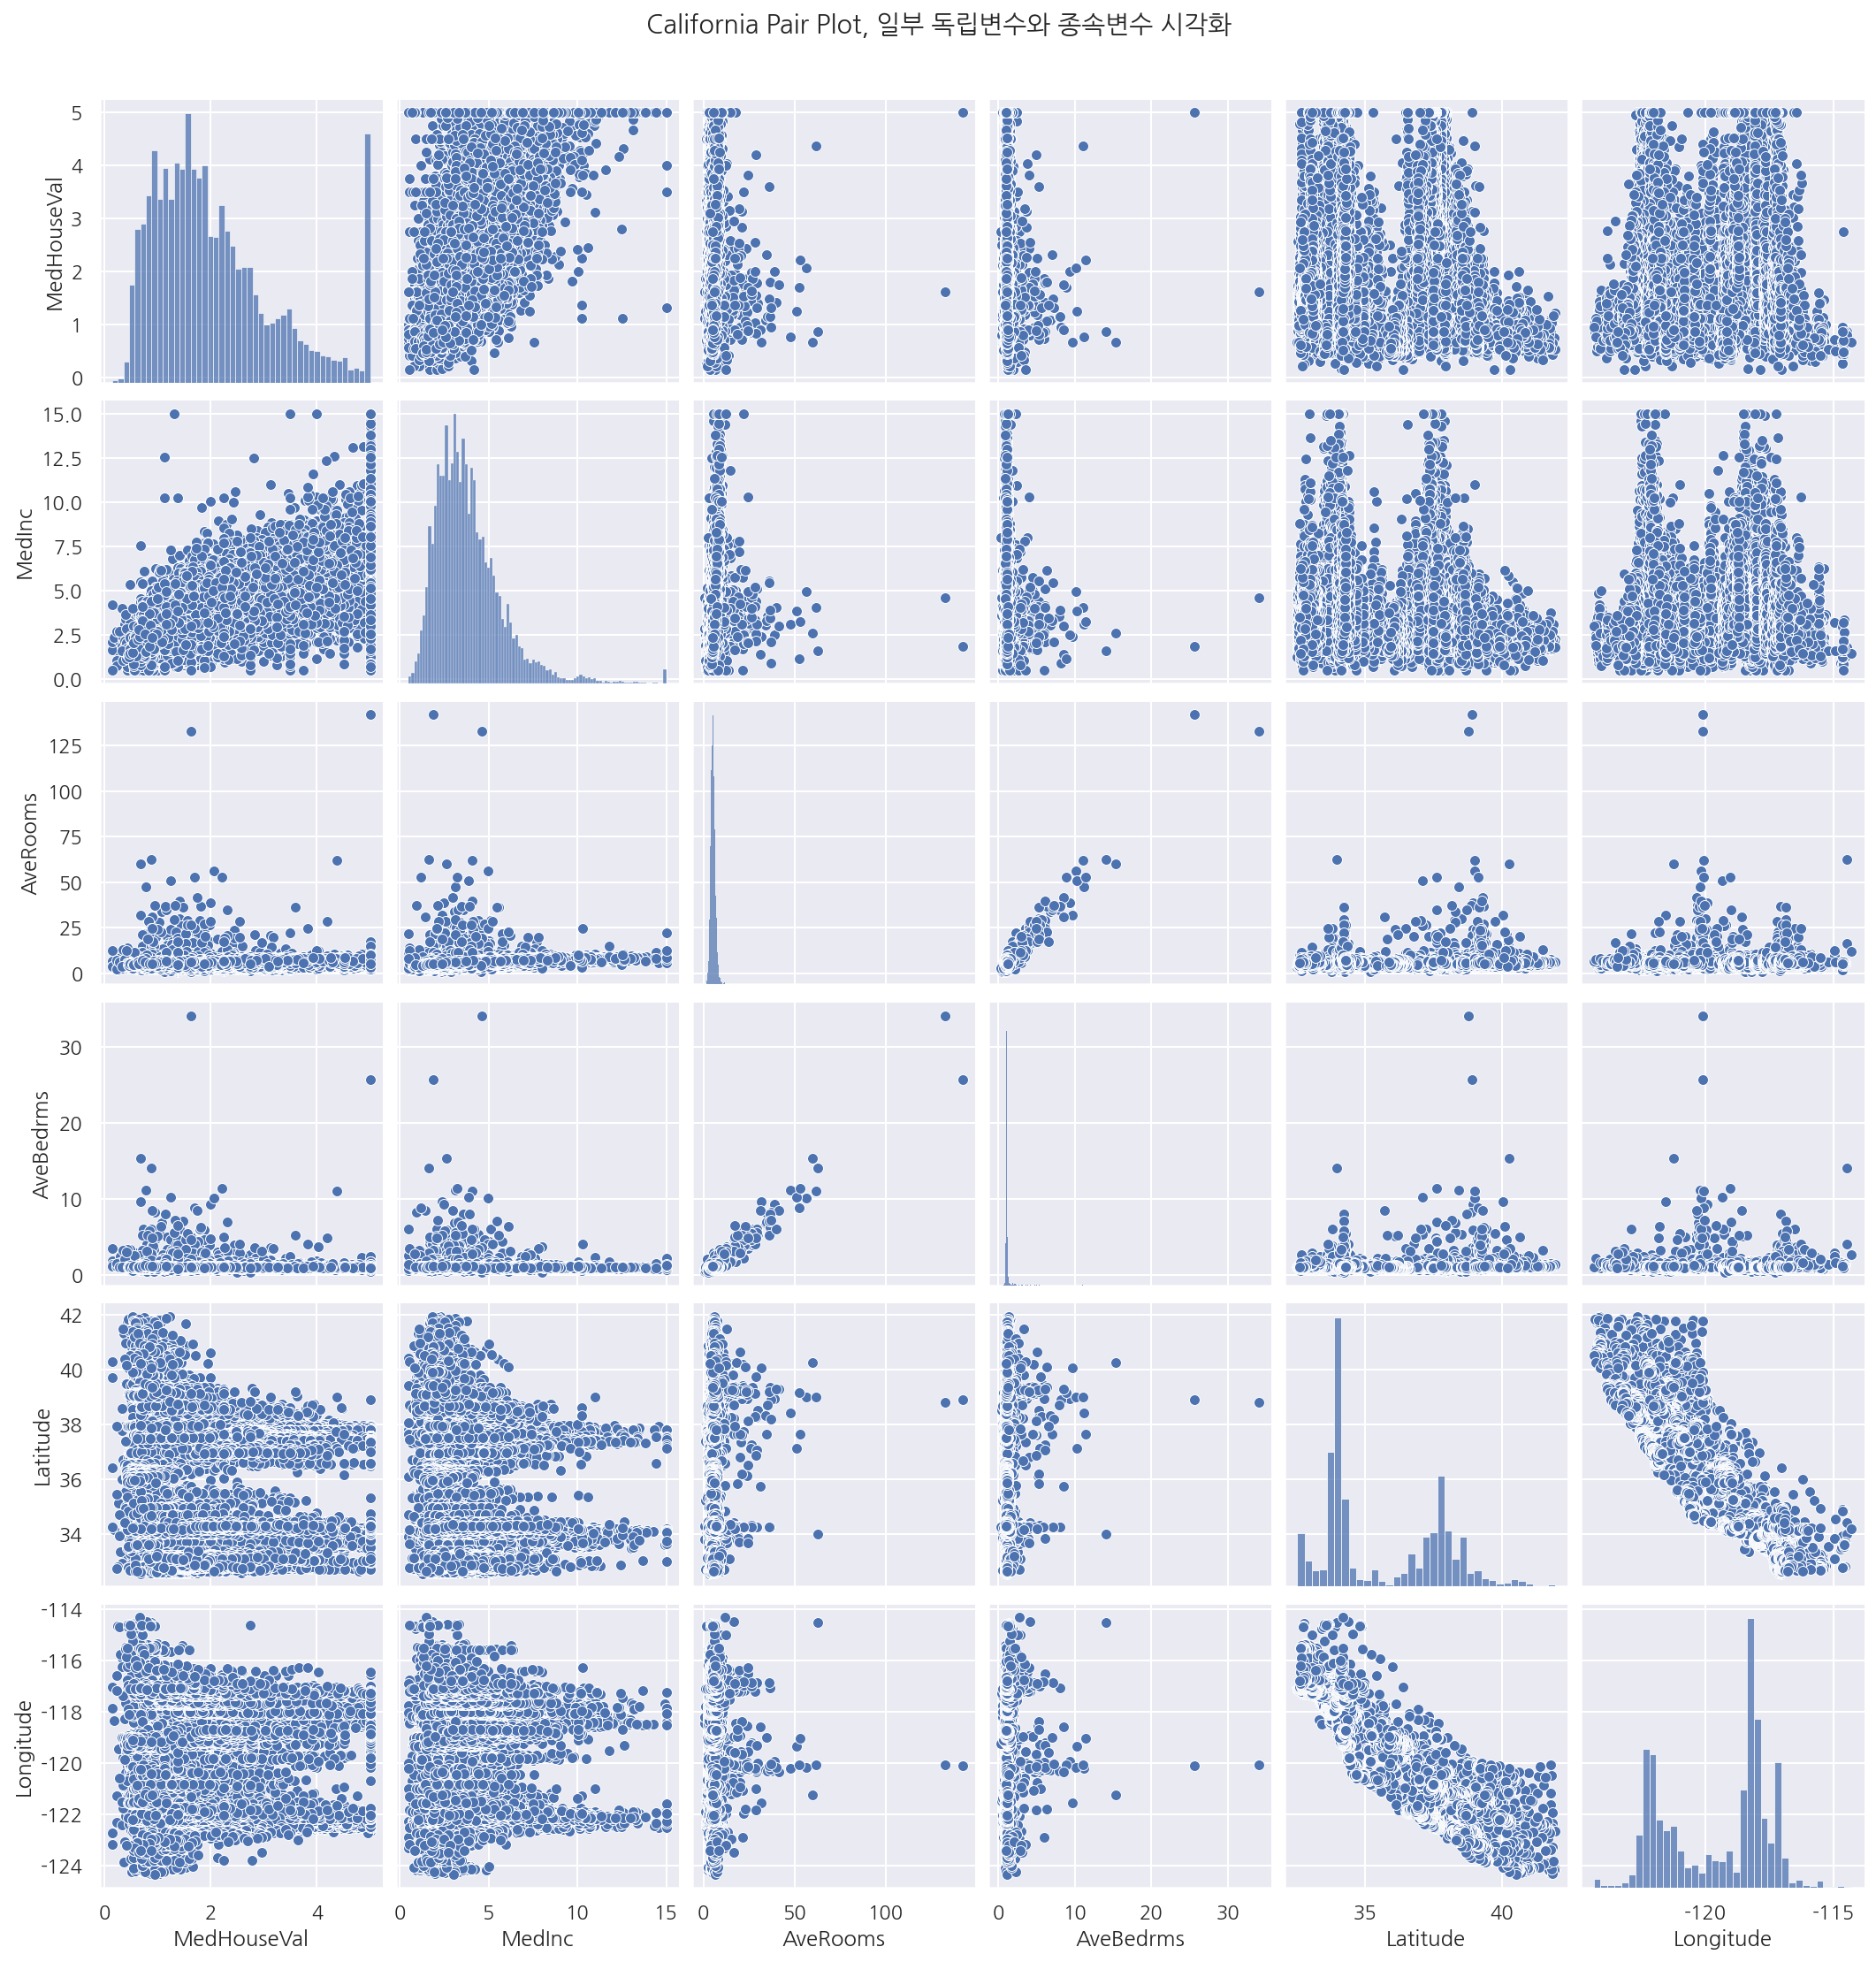

In [10]:
sns.pairplot(california[["MedHouseVal", "MedInc", "AveRooms", "AveBedrms", "Latitude", "Longitude"]])
plt.suptitle("California Pair Plot, 일부 독립변수와 종속변수 시각화", y=1.03)
plt.show()

- 상관계수로 확인 하였듯이 변수간 선형관계가 보인다.


- Latitude와 Longitude는 비선형 형태에 가까워 보인다.

## 4.1.4 가상 데이터 예측

**가상 데이터 만들기**
```python
X, Y, B  = make_regression(
    n_samples, n_features, bias, noise, random_state, coef=True, n_informative, effective_rank, tail_strength)
```

 * n_samples: 정수 (옵션, 디폴트 100)
    * 표본 데이터의 갯수 n
    
 
 * n_features: 정수 (옵션, 디폴트 100)
    * 독립변수(feature)의 수(차원) p
    
    
 * bias: 실수 (옵션, 디폴트 0)
    * Y 절편
 
 
 * noise: 실수 (옵션, 디폴트 0)
    * 오차항의 표준편차 $\epsilon$의 표준편차
 
 
 * random_state: 정수 (옵션, 디폴트 None)
   * 난수 발생용 시드값 
 
 
 * coef: 불리언 (옵션, 디폴트 False)
   * True 이면 선형 모형의 계수도 출력
 
 
 * n_informative: 정수 (옵션, 디폴트 10)
     * 독립변수(feature) 중 실제로 종속변수와 상관 관계가 있는 독립변수의 수(차원)
 
 
 * effective_rank: 정수 또는 None (옵션, 디폴트 None)
     * 독립변수(feature) 중 서로 독립인 독립변수의 수. 만약 None이면 모두 독립
 
 
 * tail_strength: 0부터 1사이의 실수 (옵션, 디폴트 0.5)
     * effective_rank가 None이 아닌 경우 독립변수간의 상관관계를 결정하는 변수. 0.5면 독립변수간의 상관관계가 없다.
     
출력은 다음과 같다.

 * X: (n_samples, n_features) 형상의 2차원 배열
    * 독립변수의 표본 데이터 행렬 $X$, n x p
 
 
 * Y: (n_samples) 형상의 1차원 배열
    * 종속변수의 표본 데이터 벡터 $Y$, n x 1
 
 
 * B: (n_features) 형상의 1차원 배열 또는 (n_features, n_targets) 형상의 2차원 배열 (옵션)
    * 선형 모형의 계수 벡터 $\beta$, p x 1 입력 인수 coef가 True 인 경우에만 출력됨

In [11]:
from sklearn.datasets import make_regression

X, Y, B = make_regression(
    n_samples=200, n_features=1, bias=2, noise=10, coef=True, random_state=1017
)

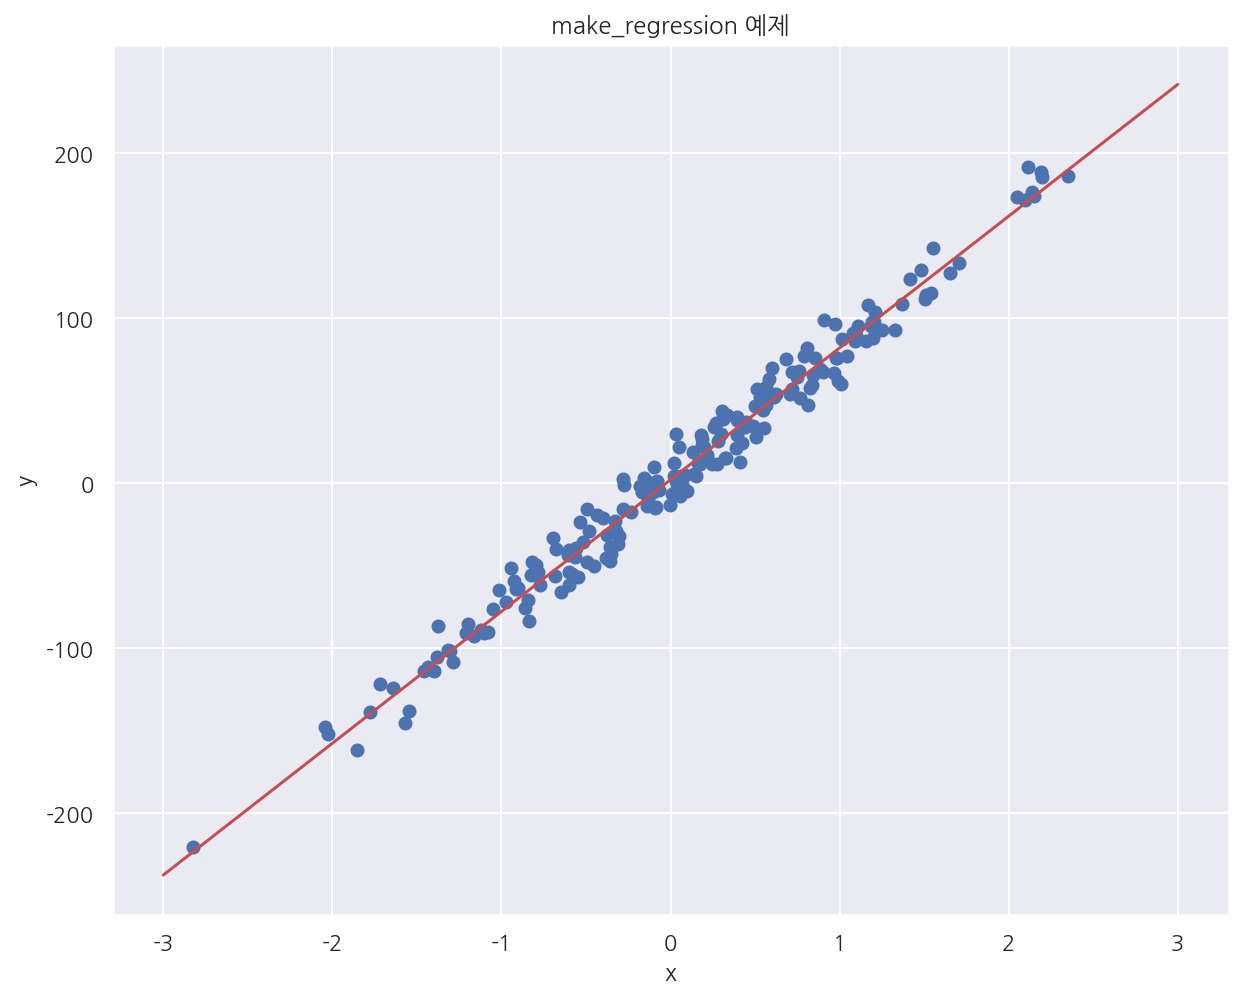

In [12]:
x = np.linspace(-3, 3, 100)
y0 = B * x + 2

plt.figure(figsize= (10,8))

# 회귀식 - 오차항 고려없이 계수로 생성, 모수 beta를 이미 알고 있음
plt.plot(x, y0, "r-")

# 산점도
plt.scatter(X, Y)

plt.xlabel("x")
plt.ylabel("y")
plt.title("make_regression 예제")

plt.show()

- `make_regression` 으로 만든 가상 데이터 산점도이다.

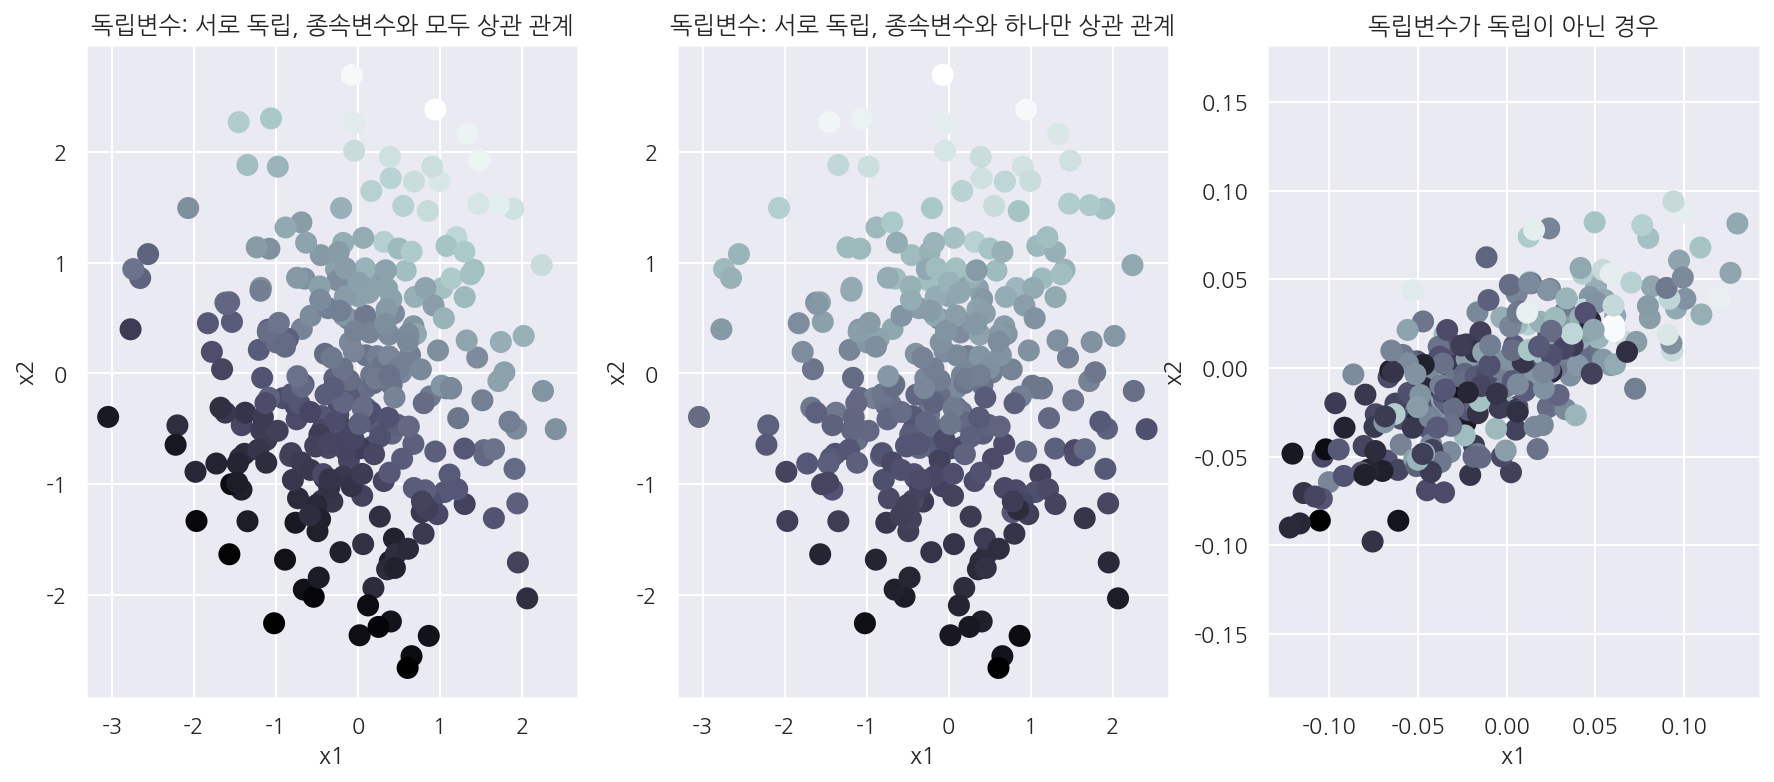

In [13]:
def make_regression2(n_informative, effective_rank, tail_strength, i):
    X, Y, B = make_regression(
        n_samples=300, n_features=2, noise=10, coef=True, random_state=0,
        n_informative = n_informative, effective_rank= effective_rank, tail_strength = tail_strength
    )
    
    axs[i].scatter(X[:, 0], X[:, 1], c=Y, s=100, cmap=mpl.cm.bone)

    axs[i].set_xlabel("x1")
    axs[i].set_ylabel("x2")

fig, axs = plt.subplots(1,3, figsize= (15,6))

make_regression2(2,None,0.5, 0)
make_regression2(1,None,0.5, 1)
make_regression2(2,1,0, 2)
    
plt.axis("equal")

axs[0].set_title("독립변수: 서로 독립, 종속변수와 모두 상관 관계")
axs[1].set_title("독립변수: 서로 독립, 종속변수와 하나만 상관 관계")
axs[2].set_title("독립변수가 독립이 아닌 경우")

plt.show()

- 종속변수 값은 점의 명암으로 표시하였으며 밝을수록 종속변숫값이 큰 것이고 점의 어두울수록 작은 값이다.


- 첫 번째 산점도에선 x1, x2 모두 증가할수록 종속변수 값이 커지는 것을 알 수 있다.


- 두 번째 산점도에선 x2가 증가할수록 종속변수 값이 증가하지만 x2에 따라선 큰 차이가 없다.


- 세 번쨰 산점도에선 x1, x2가 상관관계를 가지는 것을 확인 할 수 있다.

# 4.2 선형회귀분석의 기초

$n$개의 관측값을 가지는 $i$번째 독립변수 $x_i$는 다음과 같이 벡터로 표현가능하다. [$n$ x $1$]

$
x_i =
\begin{bmatrix}
x_{i1} \\ x_{i2} \\ \vdots \\ x_{in}
\end{bmatrix}
$

$\newline$
$n$개의 관측값을 가지고 $p$개의 독립변수를 가지는 행렬 $X$는 다음과 같다. [절편 포함: $n$ x $(p+1)$] 

$
X =
\begin{bmatrix}
1 & x_1 & x_2 & \cdots & x_p
\end{bmatrix}
\ = 
\begin{bmatrix}
1 & x_{11} & x_{21} & \cdots & x_{p1} \\
1 & x_{12} & x_{22} & \cdots & x_{p2} \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
1 & x_{1n} & x_{2n} & \cdots & x_{pn} \\
\end{bmatrix}
$

$\newline$
회귀계수 $\beta$ [($p+1$) x 1], 오차 $\epsilon$ [$n$ x 1], 종속변수 $Y$ [$n$ x 1]는 다음과 같다. 

$
\beta =
\begin{bmatrix}
\beta_{0} \\ \beta_{1} \\ \vdots \\ \beta_{p}
\end{bmatrix}
, \quad 
\epsilon =
\begin{bmatrix}
\epsilon_{0} \\ \epsilon_{1} \\ \vdots \\ \epsilon_{n}
\end{bmatrix}
, \quad 
Y =
\begin{bmatrix}
y_{0} \\ y_{1} \\ \vdots \\ y_{n}
\end{bmatrix}
= X\beta + \epsilon
$

- 만약 $X^{T}X$ 행렬의 역행렬이 존재한다면 추정회귀계수 $\hat{\beta}$ 은 다음과 같다.


- $\hat{\beta} = (X^{T}X)^{-1}X^{T}Y$


- $X^{T}X$ 행렬의 역행렬이 존재하기 위해선 각 독립변수가 서로 독립이어야 한다.

## 4.2.1 Numpy를 이용한 선형회귀분석

In [14]:
from sklearn.datasets import make_regression

# n=200, p=1, epsilon~N(0,sqrt(10))
X0, Y, B = make_regression(
    n_samples=200, n_features=1, bias=100, noise=10, coef=True, random_state=1
)

X = sm.add_constant(X0) # 상수항 결합
Y = Y.reshape(len(Y), 1)

# 모회귀계수
print("회귀계수 베타0:", 100)
print("회귀계수 베타1:", B.round(3))
print("-" * 30)

# 추정회귀계수
B_hat = np.linalg.inv(X.T @ X) @ X.T @ Y

print("추정회귀계수 베타0:", B_hat[0,0].round(3))
print("추정회귀계수 베타1:", B_hat[1,0].round(3))

회귀계수 베타0: 100
회귀계수 베타1: 86.448
------------------------------
추정회귀계수 베타0: 99.792
추정회귀계수 베타1: 86.962


- 실제 회귀계수와 비슷한 값으로 추정한 것을 확인 할 수 있다.

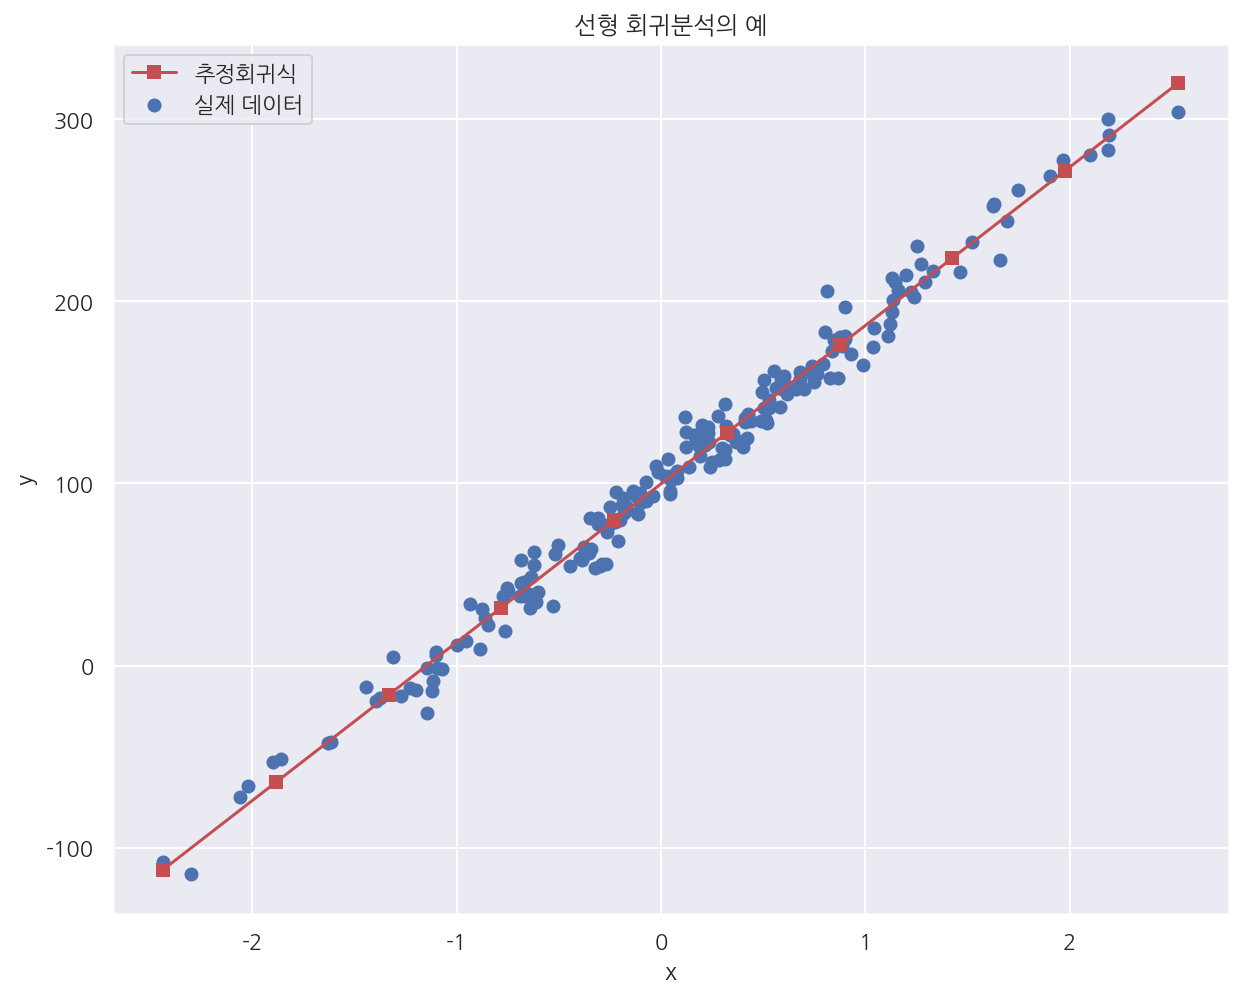

In [15]:
x_new = np.linspace(np.min(X), np.max(X), 10)
X_new = sm.add_constant(x_new)
y_new = np.dot(X_new, B_hat) # 예측값

plt.figure(figsize= (10,8))

plt.scatter(X0, Y, label="실제 데이터")
plt.plot(x_new, y_new, 'rs-', label="추정회귀식")

plt.xlabel("x")
plt.ylabel("y")
plt.title("선형 회귀분석의 예")
plt.legend()

plt.show()

## 4.2.2 scikit-learn 패키지를 사용한 선형 회귀분석

In [16]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True).fit(X0,Y)

print("추정회귀계수 베타0:", model.intercept_[0].round(3))
print("추정회귀계수 베타1:", model.coef_[0][0].round(3))

추정회귀계수 베타0: 99.792
추정회귀계수 베타1: 86.962


- `LinearRegression` 을 이용해 `Numpy`에서 수기로 계산한 값과 같은 결과를 얻었다.

In [17]:
model.predict([[-2], [-1], [0], [1], [2]])

array([[-74.13191534],
       [ 12.82979668],
       [ 99.79150869],
       [186.7532207 ],
       [273.71493272]])

- `predict` 를 이용해 새로운 x값에 대해 추정값을 구할 수 있다.


- 이때 x는 2차원 배열로 기입해야한다.

## 4.2.3 statsmodels 패키지를 사용한 선형 회귀분석

In [18]:
data = pd.DataFrame({"x": X0[:, 0], "y": Y[:, 0]})
data

,x,y
0,0.232495,127.879017
1,-0.038696,93.032914
2,0.550537,161.857508
3,0.503185,141.692050
4,2.186980,283.260119
...,...,...
195,-0.172428,87.874277
196,-1.199268,-13.626664
197,1.462108,216.106619
198,1.131629,212.743149


**독립변수와 종속변수가 다른 데이터프레임에 존재하는 경우**

In [19]:
# x에 상수항을 수기로 추가해주어야 한다.
dfy = data[["y"]]
dfX = sm.add_constant(data[["x"]])

model = sm.OLS(dfy, dfX)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 1.278e+04
Date:                Mon, 17 May 2021   Prob (F-statistic):          8.17e-182
Time:                        18:13:36   Log-Likelihood:                -741.28
No. Observations:                 200   AIC:                             1487.
Df Residuals:                     198   BIC:                             1493.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         99.7915      0.705    141.592      0.0

- 같은 회귀계수가 출력된 것을 확인 가능하며 결정계수 등 다양한 정보가 출력된다.

**독립변수와 종속변수가 같은 데이터프레임에 존재하는 경우**

In [20]:
model = sm.OLS.from_formula("y ~ x", data = data)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 1.278e+04
Date:                Mon, 17 May 2021   Prob (F-statistic):          8.17e-182
Time:                        18:13:36   Log-Likelihood:                -741.28
No. Observations:                 200   AIC:                             1487.
Df Residuals:                     198   BIC:                             1493.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     99.7915      0.705    141.592      0.0

- 동일한 결과로 출력된다.

In [21]:
result.predict({"x": [-2, -1, 0, 1, 2] })

0    -74.131915
1     12.829797
2     99.791509
3    186.753221
4    273.714933
dtype: float64

- `predict` 를 이용해 새로운 x값에 대해 추정값을 구할 수 있다.


- `predict` 외의 `params`, `resid` 등 다양한 메소드가 내제되어있다.

# 4.3 스케일링

## 4.3.1 조건수

## 4.3.2 회귀분석과 조건수

**회귀분석에서 조건수가 커지는 경우**

1. 변수들의 단위 차이로 인해 숫자의 스케일이 크게 달라지는 경우. 이 경우에는 스케일링(scaling)으로 해결한다.


2. 다중 공선성 즉, 상관관계가 큰 독립 변수들이 있는 경우, 이 경우에는 변수 선택이나 PCA를 사용한 차원 축소 등으로 해결한다.

**Boston 데이터 회귀분석**

In [22]:
from sklearn.datasets import load_boston

boston = load_boston()

dfX = pd.DataFrame(boston.data, columns=boston.feature_names)
dfy = pd.DataFrame(boston.target, columns=["MEDV"])
df = pd.concat([dfX, dfy], axis=1)

model1 = sm.OLS.from_formula("MEDV ~ " + "+".join(boston.feature_names), data=df)
result1 = model1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Mon, 17 May 2021   Prob (F-statistic):          6.72e-135
Time:                        18:13:36   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.4595      5.103      7.144      0.0

- Boston 데이터 회귀분석 결과 Notes[2]를 해석하면 다음과 같다.

    조건수(conditiona number)가 15100으로 너무 큽니다.
        
    강한 다중공선성(multicollinearity)이나 다른 수치적 문제가 있을 수 있습니다.

In [23]:
dfX.std()

CRIM         8.601545
ZN          23.322453
INDUS        6.860353
CHAS         0.253994
NOX          0.115878
RM           0.702617
AGE         28.148861
DIS          2.105710
RAD          8.707259
TAX        168.537116
PTRATIO      2.164946
B           91.294864
LSTAT        7.141062
dtype: float64

- Boston 데이터의 독립변수의 경우 단위가 0.1 수준부터 100 수준까지 혼재되어 있다.

In [24]:
feature_names = list(boston.feature_names)
feature_names.remove("CHAS") 
feature_names = [f"scale({name})" for name in feature_names] + ["CHAS"]

model3 = sm.OLS.from_formula("MEDV ~ " + "+".join(feature_names), data=df)
result3 = model3.fit()

print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Mon, 17 May 2021   Prob (F-statistic):          6.72e-135
Time:                        18:13:36   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         22.3470      0.219    101.

- 스케일링 하였을 때 조건수가 10.6으로 줄어든 것을 확인 할 수 있다.